## Tweet sentiment analysis

In this section we will see how to extract features from tweets and use a classifier to classify the tweet as positive or negative.

We will use a pandas DataFrames (http://pandas.pydata.org/) to store tweets and process them.
Pandas DataFrames are very powerful python data-structures, like excel spreadsheets with the power of python.


In [4]:
# Let's create a DataFrame with each tweet using pandas
import pandas as pd
import json
import numpy as np


def getTweetID(tweet):
    """ If properly included, get the ID of the tweet """
    return tweet.get('id')
    
def getUserIDandScreenName(tweet):
    """ If properly included, get the tweet 
        user ID and Screen Name """
    user = tweet.get('user')
    if user is not None:
        uid = user.get('id')
        screen_name = user.get('screen_name')
        return uid, screen_name
    else:
        return (None, None)
    

    
filename = 'AI2.txt'

# create a list of dictionaries with the data that interests us
tweet_data_list = []
with open(filename, 'r') as fopen:
    # each line correspond to a tweet
    for line in fopen:
        if line != '\n':
            tweet = json.loads(line.strip('\n'))
            tweet_id = getTweetID(tweet)
            user_id = getUserIDandScreenName(tweet)[0]
            text = tweet.get('text')
            if tweet_id is not None:
                tweet_data_list.append({'tweet_id' : tweet_id,
                           'user_id' : user_id,
                           'text' : text})

# put everything in a dataframe
tweet_df = pd.DataFrame.from_dict(tweet_data_list)



In [5]:
print(tweet_df.shape)
print(tweet_df.columns)

#print 5 first element of one of the column
print(tweet_df.text.iloc[:5])
# or
print(tweet_df['text'].iloc[:5])


(5012, 3)
Index(['text', 'tweet_id', 'user_id'], dtype='object')
0                                      'This Isn't AI'
1    RT @IoTRecruiting: How will Cognitive Computin...
2                        Trou* https://t.co/FlQdwMFbmh
3    RT @InvestorIdeas: https://t.co/ZFdyj2RNXV - #...
4    DeepStack: Expert-level artificial intelligenc...
Name: text, dtype: object
0                                      'This Isn't AI'
1    RT @IoTRecruiting: How will Cognitive Computin...
2                        Trou* https://t.co/FlQdwMFbmh
3    RT @InvestorIdeas: https://t.co/ZFdyj2RNXV - #...
4    DeepStack: Expert-level artificial intelligenc...
Name: text, dtype: object


In [6]:
#show the first 10 rows
tweet_df.head(10)

,text,tweet_id,user_id
0,'This Isn't AI',860217132763754497,211638860
1,RT @IoTRecruiting: How will Cognitive Computin...,860217137058635776,3226000831
2,Trou* https://t.co/FlQdwMFbmh,860217138908475397,3070524046
3,RT @InvestorIdeas: https://t.co/ZFdyj2RNXV - #...,860217141827518464,837339093214318593
4,DeepStack: Expert-level artificial intelligenc...,860217143756857344,766378262259986437
5,RT @IoTRecruiting: How will Cognitive Computin...,860217149192785920,2390579695
6,RT @IoTRecruiting: Honored to be ranked Top In...,860217150237270022,860148473873739779
7,I want Barnier to hand over the cheque with a ...,860217155568242693,740545840838774784
8,Iraqi refugee 'used asylum seekers to stage bu...,860217170948612096,14101483
9,RT @cabroncita: $BKD $BKDCD / $BKD.V Artificia...,860217174077706242,835220550209396736


### Extracting features from the tweets

#### 1) Tokenize the tweet in a list of words

This part uses concepts from [Naltural Langage Processing](https://en.wikipedia.org/wiki/Natural_language_processing).
We will use a tweet tokenizer I built based on TweetTokenizer from NLTK (http://www.nltk.org/).
You can see how it works by opening the file TwSentiment.py. The goal is to process any tweets and extract a list of words taking into account usernames, hashtags, urls, emoticons and all the informal text we can find in tweets. We also want to reduce the number of features by doing some transformations such as putting all the words in lower cases.

In [7]:
from TwSentiment import CustomTweetTokenizer

In [8]:
tokenizer = CustomTweetTokenizer(preserve_case=False, # keep Upper cases
                                 reduce_len=True, # reduce repetition of letter to a maximum of three
                                 strip_handles=False, # remove usernames (@mentions)
                                 normalize_usernames=True, # replace all mentions to "@USER"
                                 normalize_urls=True, # replace all urls to "URL"
                                 keep_allupper=True) # keep upercase for words that are all in uppercase

In [9]:
# example
tweet_df.text.iloc[0]

"'This Isn't AI'"

In [10]:
tokenizer.tokenize(tweet_df.text.iloc[0])

["'", 'this', "isn't", 'AI', "'"]

In [9]:
# other examples
tokenizer.tokenize('Hey! This is SO cooooooooooooooooool! :)')

['hey', '!', 'this', 'is', 'SO', 'coool', '!', ':)']

In [11]:
tokenizer.tokenize('Hey! This is so cooooooool! :)')

['hey', '!', 'this', 'is', 'so', 'coool', '!', ':)']

#### 2) Define the features that will represent the tweet
We will use the occurrence of words and pair of words (bigrams) as features.

This corresponds to a bag-of-words representation (https://en.wikipedia.org/wiki/Bag-of-words_model): we just count each words (or [n-grams](https://en.wikipedia.org/wiki/N-gram)) without taking account their order. For document classification, the frequency of occurence of each words is usually taken as a feature. In the case of tweets, they are so short that we can just count each words once.

Using pair of words allows to capture some of the context in which each words appear. This helps capturing the correct meaning of words.

In [12]:
from TwSentiment import bag_of_words_and_bigrams

# this will return a dictionary of features,
# we just list the features present in this tweet
bag_of_words_and_bigrams(tokenizer.tokenize(tweet_df.text.iloc[0]))

{"'": True,
 'this': True,
 "isn't": True,
 'AI': True,
 ("'", 'this'): True,
 ('this', "isn't"): True,
 ("isn't", 'AI'): True,
 ('AI', "'"): True}

#### Download the logistic regression classifier

https://www.dropbox.com/s/09rw6a85f7ezk31/sklearn_SGDLogReg_.pickle.zip?dl=1

I trained this classifier on this dataset: http://help.sentiment140.com/for-students/, following the approach from this paper: http://cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf

This is a set of 14 million tweets with emoticons. Tweets containing "sad" emoticons (7 million) are considered negative and tweets with "happy" emoticons (7 million) are considered positive.

I used a Logistic Regression classifier with L2 regularization that I optimized with a 10 fold cross-validation using $F_1$ score as a metric.


In [14]:
# the classifier is saved in a "pickle" file
import pickle

with open('sklearn_SGDLogReg_.pickle', 'rb') as fopen:
    classifier_dict = pickle.load(fopen)



D:\Anaconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator DictVectorizer from version pre-0.18 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\Anaconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator SGDClassifier from version pre-0.18 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
D:\Anaconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator Pipeline from version pre-0.18 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [15]:
# classifier_dict contain the classifier and label mappers
# that I added so that we remember how the classes are 
# encoded
classifier_dict

{'label_inv_mapper': {0: 'neg', 1: 'pos'},
 'label_mapper': {'neg': 0, 'pos': 1},
 'sklearn_pipeline': Pipeline(steps=[('feat_vectorizer', DictVectorizer(dtype=<class 'numpy.int8'>, separator='=', sort=False,
         sparse=True)), ('classifier', SGDClassifier(alpha=7.847599703514622e-06, average=False, class_weight=None,
        epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
        learning_rate='optimal', loss='log', n_iter=10, n_jobs=1,
        penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
        warm_start=False))])}

The classifier is in fact contained in a pipeline.
A sklearn pipeline allows to assemble several transformation of your data (http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)

In [16]:
pipline = classifier_dict['sklearn_pipeline']

In our case we have two steps: 

- Vectorize the textual features (using http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html)
- Classify the vectorized features (using http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)

In [17]:
pipline.steps

[('feat_vectorizer',
  DictVectorizer(dtype=<class 'numpy.int8'>, separator='=', sort=False,
          sparse=True)),
 ('classifier',
  SGDClassifier(alpha=7.847599703514622e-06, average=False, class_weight=None,
         epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
         learning_rate='optimal', loss='log', n_iter=10, n_jobs=1,
         penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
         warm_start=False))]

In [18]:
# this the step that will transform a list of textual features to a vector of zeros and ones
dict_vect = pipline.steps[0][1]

In [19]:
dict_vect.feature_names_

[':}',
 ('so', 'glad'),
 'was',
 ('that', 'was'),
 ('to', 'make'),
 'that',
 ('skool', 'this'),
 'for',
 'to',
 ('hafta', 'get'),
 'but',
 ('!', 'but'),
 'get',
 ('a', 'summer'),
 ('gay', '!'),
 ("don't", 'have'),
 ('paper', '!'),
 'this',
 'so',
 ('summer', 'skool'),
 ('!', 'I'),
 'paper',
 ('was', 'gay'),
 'make',
 ('wow', 'that'),
 ('!', ':}'),
 'glad',
 ('need', 'to'),
 ('make', 'that'),
 'have',
 ('job', 'for'),
 ('I', "don't"),
 ('!', 'wow'),
 'I',
 ('this', 'summer'),
 'a',
 ('have', 'summer'),
 'gay',
 ('get', 'a'),
 'wow',
 ('glad', 'I'),
 'summer',
 ('summer', '!'),
 ('summer', 'job'),
 'job',
 'skool',
 ('but', 'I'),
 ('sure', '!'),
 'sure',
 ('I', 'hafta'),
 'need',
 '!',
 "don't",
 'hafta',
 ('for', 'sure'),
 ('I', 'need'),
 ('that', 'paper'),
 ('only', 'on'),
 ('hot', 'milo'),
 'before',
 ('5', 'minutes'),
 'about',
 'the',
 ',',
 'heading',
 ('yup', ','),
 ('to', 'the'),
 'nice',
 ('couch', 'for'),
 ('nice', 'hot'),
 ('the', 'couch'),
 ('minutes', 'and'),
 ('for', 'about

In [20]:
# number of features
len(dict_vect.feature_names_)

3887274

In [21]:
# a little example
text = 'Hi all, I am very happy today'
# first tokenize
tokens = tokenizer.tokenize(text)
print(tokens)

# list features
features = bag_of_words_and_bigrams(tokens)
print(features)

# vectorize features
X = dict_vect.transform(features)

print(X.shape)

['hi', 'all', ',', 'I', 'am', 'very', 'happy', 'today']
{'hi': True, 'all': True, ',': True, 'I': True, 'am': True, 'very': True, 'happy': True, 'today': True, ('hi', 'all'): True, ('all', ','): True, (',', 'I'): True, ('I', 'am'): True, ('am', 'very'): True, ('very', 'happy'): True, ('happy', 'today'): True}
(1, 3887274)


In [22]:
# X is a special kind of numpy array. beacause it is extremely sparse
# it can be encoded to take less space in memory
# if we want to see it fully, we can use .toarray()

# number of non-zero values in X:
X.toarray().sum()


15

The mapping between the list of features and the vector of zeros and ones is done when you train the pipeline with its `.fit` method.

### Classifing the tweet
Now that we have vector representing the presence of features in a tweet, we can apply our logistic regression classifier to compute the probability that a tweet belong to the "sad" or "happy" category

In [23]:
classifier = pipline.steps[1][1]

In [24]:
classifier

SGDClassifier(alpha=7.847599703514622e-06, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=10, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [25]:
# access the weights of the logistic regression
classifier.coef_

array([[-0.03320511,  0.28887428, -0.29384334, ..., -0.00785218,
        -0.00785218, -0.00218135]])

In [26]:
# we have as many weights as features
classifier.coef_.shape

(1, 3887274)

In [27]:
# plus the intrecept 
classifier.intercept_

array([ 0.20885619])

In [28]:
# let's check the weight associated with a given feature
x = dict_vect.transform({'bad': True})
_, ind = np.where(x.todense())
classifier.coef_[0,ind]



array([-1.09908401])

In [29]:
# find the probability for a specific tweet
classifier.predict_proba(X)

array([[ 0.06994618,  0.93005382]])

Using the sklearn pipeline to group the two last steps:

In [30]:
pipline.predict_proba(features)

array([[ 0.06994618,  0.93005382]])

We see to numbers, the first one is the probability of the tweet being sad, the second one is the probability of the tweet being happy.

In [31]:
# note that:
pipline.predict_proba(features).sum()

1.0

### Putting it all together:

We will use the class `TweetClassifier` from TwSentiment.py that puts together this process for us:

In [32]:
from TwSentiment import TweetClassifier

In [33]:
twClassifier = TweetClassifier(pipline,
                              tokenizer=tokenizer,
                              feature_extractor=bag_of_words_and_bigrams)

In [34]:
# example
text = 'Hi all, I am very happy today'
twClassifier.classify_text(text)

('pos', array([ 0.06994618,  0.93005382]))

In [35]:
# the classify text method also accepts a list of text as input
twClassifier.classify_text(['great day today!', 'bad day today...'])
# the classify text method also accepts a list of text as input
# twClassifier.classify_text(['not sad', 'not happy'])

(array(['pos', 'neg'], 
       dtype='<U3'), array([[ 0.14707178,  0.85292822],
        [ 0.90656453,  0.09343547]]))

### We can now classify our tweets:

In [36]:
emo_clas, prob = twClassifier.classify_text(tweet_df.text.tolist())


In [37]:
# add the result to the dataframe

In [38]:
tweet_df['pos_class'] = (emo_clas == 'pos')
tweet_df['pos_prob'] = prob[:,1]

In [39]:
tweet_df.head()

,text,tweet_id,user_id,pos_class,pos_prob
0,'This Isn't AI',860217132763754497,211638860,False,0.316765
1,RT @IoTRecruiting: How will Cognitive Computin...,860217137058635776,3226000831,True,0.814357
2,Trou* https://t.co/FlQdwMFbmh,860217138908475397,3070524046,True,0.631905
3,RT @InvestorIdeas: https://t.co/ZFdyj2RNXV - #...,860217141827518464,837339093214318593,False,0.416576
4,DeepStack: Expert-level artificial intelligenc...,860217143756857344,766378262259986437,True,0.818437


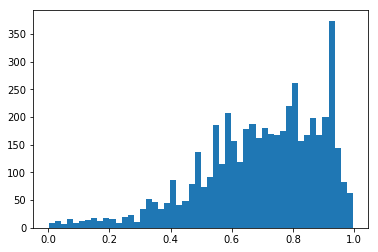

In [40]:
# plot the distribution of probability
import matplotlib.pyplot as plt
%matplotlib inline
h = plt.hist(tweet_df.pos_prob, bins=50)


We want to classify users based on the class of their tweets.
Pandas allows to easily group tweets per users using the [groupy](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html) method of DataFrames:

In [41]:
user_group = tweet_df.groupby('user_id')

In [42]:
print(type(user_group))

<class 'pandas.core.groupby.DataFrameGroupBy'>


In [43]:
# let's look at one of the group
groups = user_group.groups
uid = list(groups.keys())[5]
user_group.get_group(uid)

,text,tweet_id,user_id,pos_class,pos_prob
85,RT @hackaday: Google AIY: Artificial Intellige...,860217395314647040,787345,True,0.885622


In [44]:
# we need to make a function that takes the dataframe of tweets grouped by users and return the class of the users
def get_user_emo(group):
    num_pos = group.pos_class.sum()
    num_tweets = group.pos_class.size
    if num_pos/num_tweets > 0.5:
        return 'pos'
    elif num_pos/num_tweets < 0.5:
        return 'neg'
    else:
        return 'NA'

In [45]:
# apply the function to each group
user_df = user_group.apply(get_user_emo)

In [46]:
# This is a pandas Series where the index are the user_id
user_df.head(10)

user_id
785        pos
12774      pos
63433      pos
685063     neg
779302     pos
787345     pos
994761     pos
1246421    neg
1294621    pos
1308181    pos
dtype: object

### Let's add this information to the graph we created earlier

In [48]:
import networkx as nx

G = nx.read_graphml('twitter_lcc_AI2.graphml', node_type=int)

for n in G.nodes_iter():
    if n in user_df.index:
        # here we look at the value of the user_df series at the position where the index 
        # is equal to the user_id of the node
        G.node[n]['emotion'] = user_df.loc[user_df.index == n].values[0]

In [49]:
# we have added an attribute 'emotion' to the nodes
G.node[n]

{'name': 'Kasparov63'}

In [50]:
# save the graph to open it with Gephi
nx.write_graphml(G, 'twitter_lcc_emo_AI2.graphml')